## Prepare imports

In [2]:
from datasets.topological import DataModule, DataModuleConfig
import torch
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import pyvista as pv

from torch_geometric.data import Batch

from models.vae import VanillaVAE
from models.vae import BaseModel as BaseVAE
from models.encoder import BaseModel as EctEncoder
from layers.ect import EctLayer, EctConfig

from metrics.metrics import get_mse_metrics
from metrics.accuracies import compute_mse_accuracies
from metrics.loss import compute_mse_loss_fn
from layers.directions import generate_directions

from omegaconf import OmegaConf
import torch
import matplotlib.pyplot as plt

from models.vae import VanillaVAE,BaseModel
from metrics.metrics import get_mse_metrics
from metrics.accuracies import compute_mse_accuracies
from layers.ect import EctLayer, EctConfig

from metrics.loss import compute_mse_kld_loss_fn


DEVICE = "cuda:0"

vae_config = OmegaConf.load("./configs/config_vae_topological.yaml")
ectencoder_config = OmegaConf.load("./configs/config_encoder_topological.yaml")
dm = DataModule(DataModuleConfig())


## Load Models and Data

In [3]:
layer = EctLayer(
    EctConfig(
        num_thetas=ectencoder_config.layer.ect_size,
        bump_steps=ectencoder_config.layer.ect_size,
        normalized=True,
        device=DEVICE,
    ),
    v=generate_directions(ectencoder_config.layer.ect_size, ectencoder_config.layer.dim, DEVICE),
)

# Load the encoder 

ect_encoder_litmodel = EctEncoder.load_from_checkpoint(
    f"./trained_models/ectencoder_topological.ckpt",
    layer=layer,
    ect_size=ectencoder_config.layer.ect_size,
    hidden_size=ectencoder_config.model.hidden_size,
    num_pts=ectencoder_config.model.num_pts,
    num_dims=ectencoder_config.model.num_dims,
    learning_rate=ectencoder_config.model.learning_rate,
).to(DEVICE)

vae_model = VanillaVAE(
    in_channels=vae_config.model.in_channels,
    latent_dim=vae_config.model.latent_dim,
    img_size=vae_config.layer.ect_size,
)

# Load the VAE model

metrics = get_mse_metrics()

vae_litmodel = BaseModel.load_from_checkpoint(
    f"./trained_models/{vae_config.model.save_name}",
    model=vae_model,
    training_accuracy=metrics[0],
    test_accuracy=metrics[1],
    validation_accuracy=metrics[2],
    accuracies_fn=compute_mse_accuracies,
    loss_fn=compute_mse_kld_loss_fn,
    learning_rate=vae_config.litmodel.learning_rate,
    layer=layer,
).to(DEVICE)


In [4]:
# batch_len = len(dm.test_dataloader())
test_ds = dm.test_ds

# For each class, grab 16 samples.
mfld_classes = test_ds.y.unique() 

test_data_list = []

for idx in mfld_classes: 
    test_data_list.extend([test_ds[test_ds.y == idx][i] for i in range(1)])


test_batch = Batch.from_data_list(test_data_list).to(DEVICE)
points_batch = test_batch.x.cpu().detach().view(-1,1024,3).numpy()


In [5]:
import pyvista as pv

ect = layer(test_batch,test_batch.batch).unsqueeze(1)


with torch.no_grad():
    recon_pts = ect_encoder_litmodel.model.forward(ect)
    recon_ect_vae, theinput, z_mean, z_log_var = vae_litmodel.forward(ect)

# Undo the VAE transform
recon_ect_vae = (recon_ect_vae + 1 ) / 2

with torch.no_grad():
    recon_vae_pts = ect_encoder_litmodel.model.forward(recon_ect_vae).cpu().detach().numpy()




pl = pv.Plotter(shape=(2, 4), window_size=[800, 400],border=False,polygon_smoothing=True)

row=2
for idx in range(4):
    points_vae = recon_vae_pts[idx].reshape(-1, 3)
    pl.subplot(0, idx)
    actor = pl.add_points(
        points_vae,
        style="points",
        emissive=False,
        show_scalar_bar=False,
        render_points_as_spheres=True,
        scalars=points_vae[:, 2],
        point_size=5,
        ambient=0.2, 
        diffuse=0.8, 
        specular=0.8,
        specular_power=40, 
        smooth_shading=True
    )

    points = recon_pts[idx].reshape(-1, 3).cpu().detach().numpy()
    pl.subplot(1, idx)
    actor = pl.add_points(
        points,
        style="points",
        emissive=False,
        show_scalar_bar=False,
        render_points_as_spheres=True,
        scalars=points[:, 2],
        point_size=5,
        ambient=0.2, 
        diffuse=0.8, 
        specular=0.8,
        specular_power=40, 
        smooth_shading=True
    )



pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10

# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
pl.screenshot("./figures/img/topological/reconstructed_pointcloud.png",transparent_background=True,scale=2)
pl.show()



Widget(value='<iframe src="http://localhost:64571/index.html?ui=P_0x221f8377eb0_0&reconnect=auto" class="pyvis…

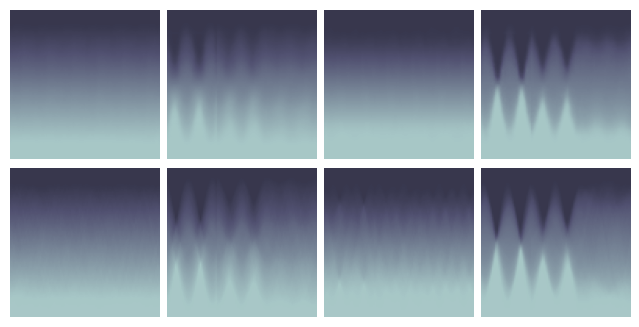

In [6]:
# Plot ect

n_images = 4

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(8,4)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for orig_img, recon_img,ax in zip(ect,recon_ect_vae,axes.T):
    
    ax[0].imshow(recon_img.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax[0].axis("off")
    ax[1].imshow(orig_img.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax[1].axis("off")
    

plt.savefig("./figures/img/topological/reconstructed_ect_vae.svg",transparent=True)

## Sample from VAE and reconstruct points 

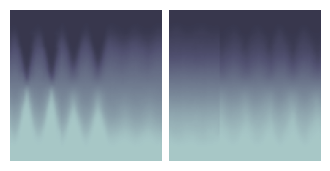

In [11]:
samples = vae_litmodel.model.sample(64, "cuda:0")
samples = (samples + 1 ) / 2

n_images = 2

fig, axes = plt.subplots(
    nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(4,4)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for sample, ax in zip(samples,axes.T):
    ax.imshow(sample.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax.axis("off")

plt.savefig("./figures/img/topological/generated_samples.svg",transparent=True)

In [12]:

import pyvista as pv

pl = pv.Plotter(shape=(1, 2), window_size=[400, 200],border=False,polygon_smoothing=True)

with torch.no_grad():
    batch_decoded = ect_encoder_litmodel.model.forward(samples)

batch_decoded = batch_decoded.cpu().detach().numpy()

points = batch_decoded[0].reshape(-1, 3)
pl.subplot(0,0)
actor = pl.add_points(
    points,
    style="points",
    emissive=False,
    show_scalar_bar=False,
    render_points_as_spheres=True,
    scalars=points[:, 2],
    point_size=5,
    ambient=0.2, 
    diffuse=0.8, 
    specular=0.8,
    specular_power=40, 
    smooth_shading=True
)


points = batch_decoded[1].reshape(-1, 3)
pl.subplot(0,1)
actor = pl.add_points(
    points,
    style="points",
    emissive=False,
    show_scalar_bar=False,
    render_points_as_spheres=True,
    scalars=points[:, 2],
    point_size=5,
    ambient=0.2, 
    diffuse=0.8, 
    specular=0.8,
    specular_power=40, 
    smooth_shading=True
)



pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10

# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
pl.screenshot("./figures/img/topological/generated_samples.png",transparent_background=True,scale=2)
pl.show()

Widget(value='<iframe src="http://localhost:64571/index.html?ui=P_0x22242b8fc40_3&reconnect=auto" class="pyvis…